<a href="https://colab.research.google.com/github/rhiats/pimaDiab/blob/main/pima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score
!pip install shap
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


**Load Data**

In [2]:
df=pd.read_csv("/content/drive/MyDrive/assignments/Spring24/Spec Project/diabetes.csv")
df.insert(0, 'ID', range(0, len(df)))
df.head()
df.astype(int)
df['Outcome'] = np.where(df['Outcome']==0, 'Healthy', 'Diabetic')

In [3]:
df.columns

Index(['ID', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

**Class Balance**

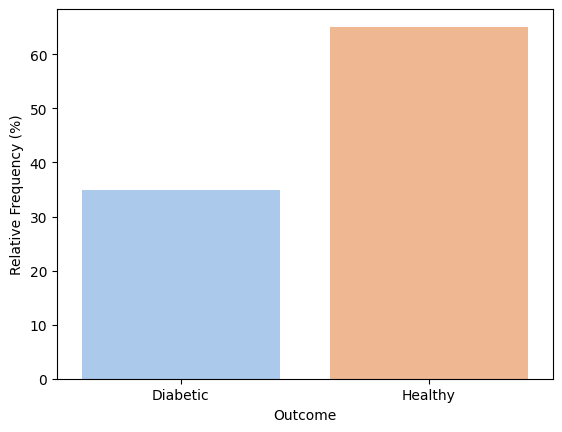

In [4]:
def balanced(df):
  """
    Percentage of passengers with Diabetes and those without Diabetes
    Balanced or Imbalanced Data

    @p:
      df (dataframe): Input dataframe
  """

  ratio_df=(df[['ID','Outcome']].groupby('Outcome').count()/df.shape[0])*100

  ratio_df.reset_index(inplace=True)

  ratio_df.rename(columns={"ID": "Relative Frequency (%)"}, inplace=True)

  sns.barplot(data=ratio_df, x='Outcome', y="Relative Frequency (%)", palette="pastel")

  plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/balanced.png")

balanced(df)

**PCA**

Based on the loadings the top three important features are Insulin, Glucose, and SkinThickness to predict the likelihood of Diabetes. The first component explains 94% of the variance in the data.

It may be beneficial to normalize the data to minimize the influence of any outliers on the analysis.

Reference:

https://www.datacamp.com/tutorial/principal-component-analysis-in-python

https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html

https://stats.stackexchange.com/questions/27300/using-principal-component-analysis-pca-for-feature-selection

In [5]:
pca = PCA(n_components=2)
X=df.to_numpy()
X=X[:,1:-1]
X = pca.fit_transform(X)

In [6]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.88854663 0.06159078]


In [7]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1','PC2'], index=df.columns[1:-1])
loadings.sort_values(by=['PC1'], ascending=False)

,PC1,PC2
Insulin,0.993111,0.094627
Glucose,0.097812,-0.972210
SkinThickness,0.060757,0.057861
BloodPressure,0.016093,-0.141909
BMI,0.014011,-0.046973
DiabetesPedigreeFunction,0.000537,-0.000817
Pregnancies,-0.002022,-0.022649
Age,-0.003565,-0.140168


**Project Instances for Visualization**

In [8]:
principalComponents_arr = pca.fit_transform(X)
principalComponents_df= pd.DataFrame(principalComponents_arr, columns = ['PC1','PC2'])

<Figure size 640x480 with 0 Axes>

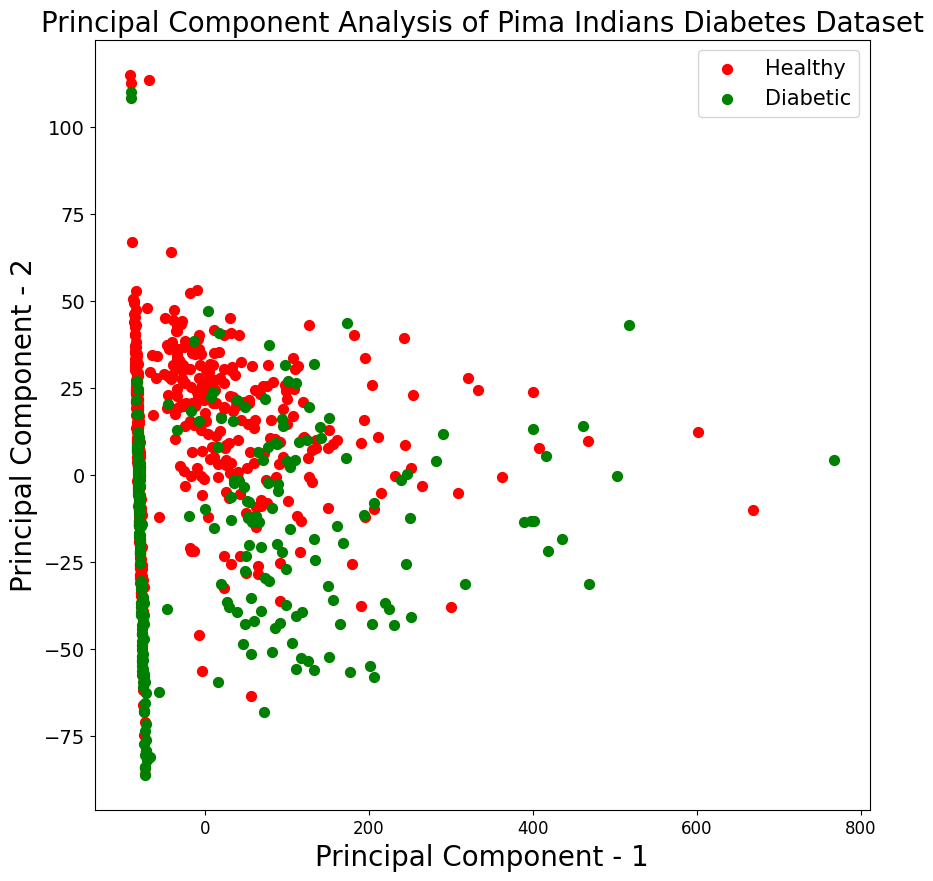

In [9]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Pima Indians Diabetes Dataset",fontsize=20)
targets = ['Healthy', 'Diabetic']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    df_target=df[df['Outcome'] == target]
    indicesToKeep=df_target.index
    plt.scatter(principalComponents_df.loc[indicesToKeep, 'PC1'] , principalComponents_df.loc[indicesToKeep, 'PC2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/pca.png")

**Conditional Probability**

- Liklihood Someone is has diabetes given they are Overweight (BMI >=25)
- Probability a person is Diabetic Given that she had at least 3 pregnancies

https://www.ramsayhealth.co.uk/weight-loss-surgery/bmi/bmi-for-women

In [10]:
Overweight_and_diabetic_df=df[(df['Outcome']=='Diabetic') & (df['BMI']>=25)]
Overweight_df=df[(df['BMI']>=25)]
prob_diabetic_given_overweight=round((Overweight_and_diabetic_df.shape[0]/Overweight_df.shape[0])*100)
'The probability a person develops Diabetes given she is overweight is {}%'.format(prob_diabetic_given_overweight)

'The probability a person develops Diabetes given she is overweight is 40%'

In [11]:
Preg_and_diabetic_df=df[(df['Outcome']=='Diabetic') & (df['Pregnancies']>=3)]
Preg_df=df[(df['Pregnancies']>=3)]
prob_diabetic_given_preg3=round((Preg_and_diabetic_df.shape[0]/Preg_df.shape[0])*100)
'The probability a person develops Diabetes given she has at least 3 pregnancies is {}%'.format(prob_diabetic_given_preg3)

'The probability a person develops Diabetes given she has at least 3 pregnancies is 43%'

**Distributions**

Histogram plot

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

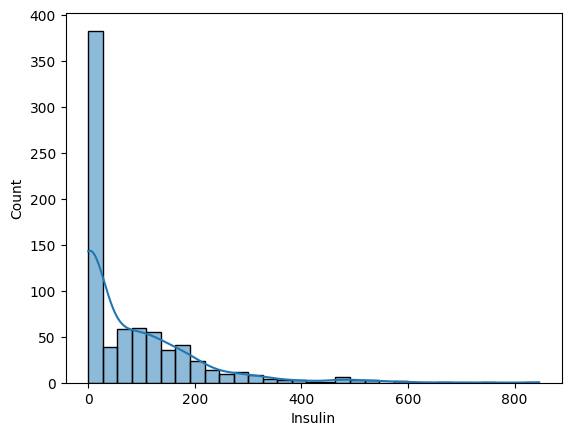

In [12]:
sns.histplot(data=df, x="Insulin",kde=True)
plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/insulin_distribution.png")
df.Insulin.describe()

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

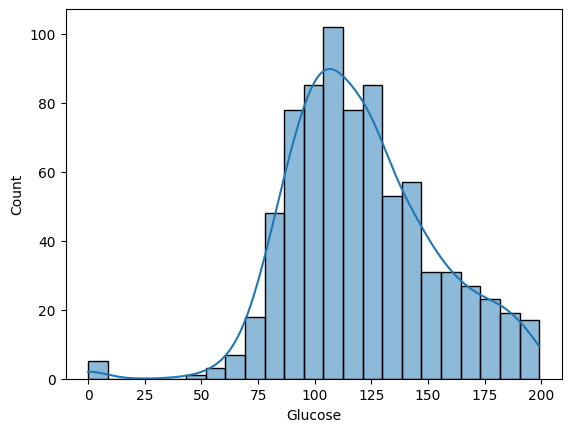

In [13]:
sns.histplot(data=df, x="Glucose",kde=True)
plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/glucose_distribution.png")
df.Glucose.describe()

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64

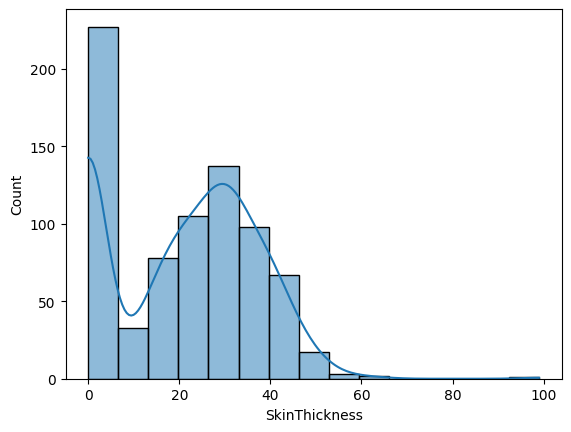

In [14]:
sns.histplot(data=df, x="SkinThickness",kde=True)
plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/SkinThickness_distribution.png")
df.SkinThickness.describe()

**T-Test**

Is the Median/Average Age of a woman who is Diabetic significantly different from the age of a woman who is not Diabetic?

In [15]:

def t_test_survival(df):
  """
    Is the Median/Average Age of a woman who is Diabetic significantly
    different from the age of a woman who is not Diabetic?

    https://www.datacamp.com/tutorial/an-introduction-to-python-t-tests?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720830&utm_adgroupid=143216588377&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=661628555645&utm_targetid=dsa-1947282172981&utm_loc_interest_ms=&utm_loc_physical_ms=9004416&utm_content=dsa~page~community-tuto&utm_campaign=230119_1-sea~dsa~tutorials_2-b2c_3-us_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na&gclid=CjwKCAjwivemBhBhEiwAJxNWNyNhPMWI2_jEAUejU7VXHpPFlhbQYhS5W2wSmKHL-KiPZUM-DzKitBoCqS8QAvD_BwE

  """

  df_diab=df[df['Outcome']=='Diabetic']

  df_healthy=df[df['Outcome']=='Healthy']

  N1, N2 = df_diab.shape[0], df_healthy.shape[0]

  # Degrees of freedom
  dof = min(N1,N2) - 1
  print(dof)

  # Gaussian distributed data with mean of fare who died and var = 1
  x = np.random.randn(N1) + df_diab["Age"]

  # Gaussian distributed data with mean of fare who survived and var = 1
  y = np.random.randn(N2) + df_healthy["Age"]

  ## Using the internal function from SciPy Package
  t_stat, p_val = stats.ttest_ind(x, y, equal_var = False)
  print("t-statistic = " + str(t_stat))
  print("p-value = " + str(p_val))

t_test_survival(df)

267
t-statistic = 6.851421134294039
p-value = 1.887031245297078e-11


In [16]:
diab_age=df[df['Outcome']=='Diabetic']['Age']
diab_age.describe()

count    268.000000
mean      37.067164
std       10.968254
min       21.000000
25%       28.000000
50%       36.000000
75%       44.000000
max       70.000000
Name: Age, dtype: float64

In [17]:
healthy_age=df[df['Outcome']=='Healthy']['Age']
healthy_age.describe()

count    500.000000
mean      31.190000
std       11.667655
min       21.000000
25%       23.000000
50%       27.000000
75%       37.000000
max       81.000000
Name: Age, dtype: float64

**Naive Bayes Classification of Patients**

In [18]:
X=df[['Glucose','SkinThickness','Insulin']]
y=df['Outcome']
y = np.where(y=='Healthy', 0, 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

**F1 Score**

In [20]:
print("The f1 score is {}".format(round(f1_score(y_test, y_pred),2)))

The f1 score is 0.51


**Receiving Operating Curve (ROC Curve)**

https://www.w3schools.com/python/python_ml_auc_roc.asp

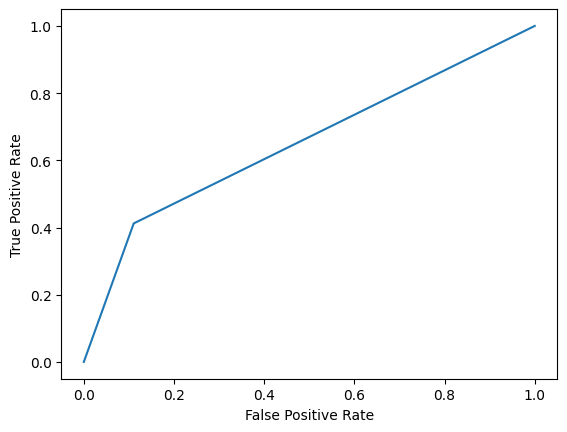

In [25]:
def plot_roc_curve(true_y, y_prob):
    """
    Plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/ROC_curve.png")

plot_roc_curve(y_test,y_pred)

In [24]:
print(f'Model AUC score: {roc_auc_score(y_test,y_pred)}')

Model AUC score: 0.650770901849561


**Confusion Matrix**

In [27]:
cf_mat = confusion_matrix(y_test,y_pred)

In [29]:
print('Confusion matrix\n\n',cf_mat)

Confusion matrix

 [[225  28]
 [ 77  54]]


In [31]:
print("The precision score: {}\n\n The recall score: {} \n\n".format(precision_score(y_test,y_pred), recall_score(y_test,y_pred)))

The precision score: 0.6585365853658537

 The recall score: 0.4122137404580153 




**Feature Importance**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


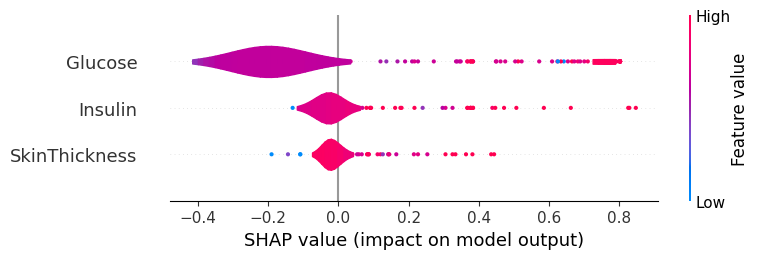

In [40]:
explainer = shap.Explainer(gnb.predict,X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, plot_type='violin')